Oct-Nov 2020, Adi Watzman. Based on a code by Dan Bareket. 
Parse 1 day of data to compare Siri 2.7 to 2.8 versions.  
2.7 is the current "production" version for us, base on siri_retreiver Java code that queries MoT's servers for all last stops.   
2.8 is a new version, that allows MUCH simpler query, and get all currently driving buses without any quering hack.   
However, we want to make sure we get the same data with both versions before we switch to 2.8 for "production".

In preliminary check, dan found differences.

In the following analysis, for one day of data (Sep. 15, 2020) we also see that 2.7 has more rides and points than 2.8.  

The data was manually downloaded from our S3 server.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas as pd
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

In [3]:
import datetime as dt

In [4]:
data_dir = '/Users/awatzman/Documents/OpenBusDocuments/data/' \
           '2020-10-12_compare_siri_2.7_2.8'
siri_27_dir = join(data_dir, 'siri_27_2020-09-15') # 14 csv.gz files
siri_28_dir = join(data_dir, 'siri_28_2020-09-15') #  json.gz files (~120 per hour)


# Read 2.8 files

In [5]:
from siri_parser import read_siri28_file, read_siri28_files

In [6]:
path1 = join(siri_28_dir, 'siri_snap_normal_2020-09-15T000001.json.gz')

In [7]:
df = read_siri28_file(path1)

In [8]:
df.shape

(817, 26)

In [9]:
from pathlib import Path

In [10]:
files = Path(siri_28_dir).rglob('*.json.gz')  # recursive search
files = [x for x in files]
len(files)

2596

In [48]:
%%time
df_28_day = read_siri28_files(siri_28_dir, max_files=None)

/Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-09-15/siri_snap_normal_2020-09-15T163631.json.gz Expecting value: line 1 column 1 (char 0)
CPU times: user 24min 56s, sys: 58.1 s, total: 25min 54s
Wall time: 26min 4s


In [49]:
df_28_day.shape

(11493501, 26)

In [50]:
## TODO - check why in the original flow 
df_28_day['origin_aimed_departure_time'] = pd.to_datetime(df_28_day['origin_aimed_departure_time'], utc=True)

In [51]:
df_28_day.dtypes

recorded_at_time               datetime64[ns, pytz.FixedOffset(180)]
item_identifier                                                int64
monitoring_ref                                                 int64
line_ref                                                       int64
direction_ref                                                  int64
data_frame_ref                                                object
dated_vehicle_journey_ref                                      int64
published_line_name                                           object
operator_ref                                                category
destination_ref                                                int64
origin_aimed_departure_time                      datetime64[ns, UTC]
longitude                                                    float32
latitude                                                     float32
bearing                                                        int64
velocity                          

In [52]:
df_28_day.to_feather('df_28_day_50.feather')

In [54]:
df_28_day2 = pd.read_feather('df_28_day_50.feather')
df_28_day2.shape

(11493501, 26)

In [84]:
df_28_day.shape

(11493501, 26)

In [55]:
# number of rides:
# By: agency, route, bus, start_time
df_28_day2.drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time'], keep='first').shape

(73057, 26)

In [134]:
# number of rides without 0:
# By: agency, route, bus, start_time
df_28_rides = df_28_day2[df_28_day2.latitude != 0].groupby([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time']).size()

# df_28_rides = df_28_day2[df_28_day2.latitude != 0].drop_duplicates([
#     'operator_ref', 'line_ref', 'vehicle_ref', 
#     'origin_aimed_departure_time'], keep='first')
df_28_rides.shape

(73057,)

2.8 does not have entire 0 rides.

In [97]:
# number of responses deduped (GPS points) without 0:
# By: agency, route, bus, start_time, recorded_at_time
df_28_day_dedup = df_28_day2[df_28_day2.latitude != 0].drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time', 'recorded_at_time'], 
    keep='first')
df_28_day_dedup.shape

(2169148, 26)

# Read 2.7 files

In [60]:
from siri_parser import read_siri27_files

In [62]:
%%time
df_27_day = read_siri27_files(siri_27_dir, max_files=None)

CPU times: user 23 s, sys: 2.09 s, total: 25 s
Wall time: 16.2 s


In [63]:
df_27_day.shape

(3550684, 14)

In [64]:
df_27_day.columns

Index(['planned_start_dt', 'predicted_end_dt', 'dt_recorded', 'timestamp',
       'agency_id', 'route_id', 'route_short_name', 'service_id', 'bus_id',
       'lat', 'lon', 'stop_point_ref', 'date', 'num_duplicates'],
      dtype='object')

In [65]:
# number of rides:
# By: agency, route, bus, start_time
df_27_day.drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt'], keep='first').shape

(118477, 14)

In [137]:
# number of rides without 0:
# By: agency, route, bus, start_time

df_27_rides = df_27_day[df_27_day.lat != 0].groupby([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt']).size()

# df_27_rides = df_27_day[df_27_day.lat != 0].drop_duplicates([
#     'agency_id', 'route_id', 'bus_id', 
#     'planned_start_dt'], keep='first')
df_27_rides.shape

(102147,)

In [96]:
# number of responses deduped (GPS points), without 0:
# By: agency, route, bus, start_time, recorded_at_time
df_27_day_dedup = df_27_day[df_27_day.lat != 0].drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt', 'dt_recorded'], 
    keep='first')
df_27_day_dedup.shape

(3091346, 14)

# Compare versions

## GPS points comparison

2.8 data availability check:

In [117]:
import os.path

2596


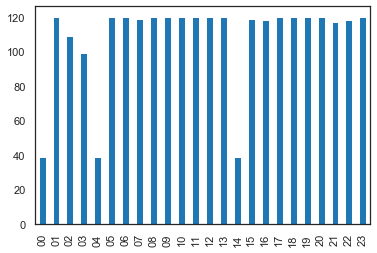

In [124]:
# plot number of files per hour in 2.8
files_28 = [os.path.basename(x) for x in Path(siri_28_dir).rglob('*.json.gz')]  # recursive search
print(len(files_28))

files_hour_28 = [x.split('-15T')[1].split('.')[0][:2] for x in files_28]
pd.Series(files_hour_28).value_counts().sort_index().plot.bar()
plt.show()


We see that we have data issues for hours 00, 04, 14. We expect to have 120 files per hour, for a query sent every 30 seconds.

In [98]:
# When grouping by agency
agency_27 = df_27_day_dedup.groupby('agency_id').size().rename('agency_27')
agency_28 = df_28_day_dedup.groupby('operator_ref').size().rename('agency_28')

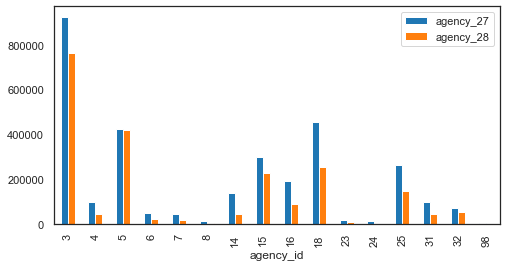

In [99]:
agency_27.to_frame().join(agency_28).plot.bar(figsize=(8, 4))
plt.show()

In [100]:
# When grouping by hour
hour_27 = df_27_day_dedup.groupby(df_27_day_dedup.dt_recorded.dt.hour).size().rename('hour_27')
hour_28 = df_28_day_dedup.groupby(df_28_day_dedup.recorded_at_time.dt.hour).size().rename('hour_28')

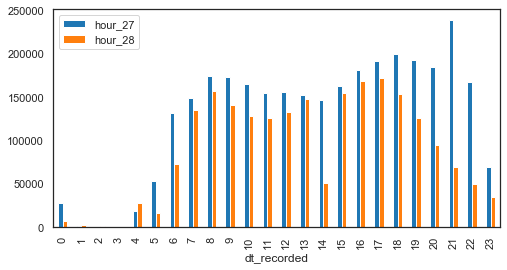

In [101]:
hour_27.to_frame().join(hour_28).plot.bar(figsize=(8, 4))
plt.show()

We see data is missing between 2.7 and 2.8 not only when we expect issues because of 2.8 data availability issues (see above).

## Rides comparison

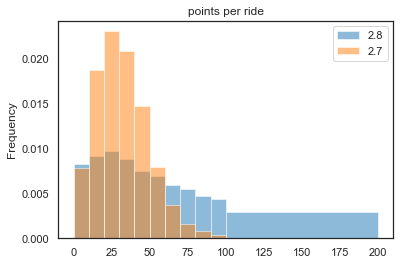

In [153]:
# Number of points per ride:
fig, ax = plt.subplots(1,1)
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
df_28_rides.plot.hist(bins=bins, ax=ax, label='2.8', alpha=0.5, density=True)
df_27_rides.plot.hist(bins=bins, ax=ax, label='2.7', alpha=0.5, density=True)
plt.legend()
plt.title("points per ride")
plt.show()


In [132]:
df_27_rides[['agency_id', 'route_id', 'bus_id', 'planned_start_dt']].sort_values('planned_start_dt')#.head()

,agency_id,route_id,bus_id,planned_start_dt
552975,3,28214,8771101,2020-09-13 10:10:00
554369,3,28210,7794069,2020-09-13 11:57:00
552976,3,28214,8758001,2020-09-13 13:20:00
569500,3,6702,7663069,2020-09-13 17:30:00
552977,3,28214,7714969,2020-09-13 21:10:00
...,...,...,...,...
1040937,7,18881,37580301,2020-09-16 11:00:00
2758870,7,17407,37580301,2020-09-16 12:50:00
1465555,7,17408,37580301,2020-09-16 15:00:00
1882316,7,17408,37580301,2020-09-16 19:00:00


In [131]:
df_28_rides[['operator_ref', 'line_ref', 'vehicle_ref', 'origin_aimed_departure_time']]\
    .sort_values('origin_aimed_departure_time').head()

,operator_ref,line_ref,vehicle_ref,origin_aimed_departure_time
107868,2,27809,956,1899-12-31 22:00:00+00:00
1769374,18,10523,7395187,2020-09-14 08:11:11+00:00
587449,3,10393,8732501,2020-09-14 16:36:00+00:00
7822598,5,2457,9283901,2020-09-14 18:20:00+00:00
511321,5,2492,9245801,2020-09-14 18:20:00+00:00


In [127]:
# join rides and look for discrepencies
rides = df_27_rides.merge(df_28_rides, how='outer',
    left_on=['agency_id', 'route_id', 'bus_id', 'planned_start_dt'],
    right_on=['operator_ref', 'line_ref', 'vehicle_ref', 'origin_aimed_departure_time']
)
print(df_27_rides.shape, df_28_rides.shape, rides.shape)

ValueError: You are trying to merge on datetime64[ns] and datetime64[ns, UTC] columns. If you wish to proceed you should use pd.concat

# OLD & Tries:

# [Appendix] Missing 2.8 files

In [5]:
import glob
import os.path

In [98]:
#sanity check to find missing files in siri 2.8:
hours = [dt.time(i).strftime('%H') for i in range(24)]

for h in hours:
    res = glob.glob(join(siri_28_dir, "*T{}*.json.gz".format(h)))
    print(h, len(res))
    res2 = []
    for item in res:
        t = os.path.basename(item).split('T')[1][:6]
        res2.append((t[2:4], t[4:6]))

    res3 = dict()
    for hr, mn in res2:
        if hr not in res3:
            res3[hr] = [mn]
        else:
            res3[hr].append(mn)

    missing = [(k, v) for k, v in res3.items() if len(v) < 2]
    if missing:
        print(h, missing)
        for m in missing:
            print('siri_snap_normal_2020-09-15T{}{}{}.json.gz'.format(
                h, m[0], '01' if m[1][0] in ("31", "32") else '31'))
    

00 39
00 [('19', ['01'])]
siri_snap_normal_2020-09-15T001931.json.gz
01 120
02 109
02 [('54', ['01'])]
siri_snap_normal_2020-09-15T025431.json.gz
03 99
03 [('49', ['01'])]
siri_snap_normal_2020-09-15T034931.json.gz
04 39
04 [('19', ['01'])]
siri_snap_normal_2020-09-15T041931.json.gz
05 120
06 120
07 119
07 [('00', ['31'])]
siri_snap_normal_2020-09-15T070001.json.gz
08 120
09 120
10 120
11 120
12 120
13 120
14 39
14 [('19', ['01'])]
siri_snap_normal_2020-09-15T141931.json.gz
15 119
15 [('47', ['01'])]
siri_snap_normal_2020-09-15T154731.json.gz
16 118
16 [('08', ['31']), ('00', ['31'])]
siri_snap_normal_2020-09-15T160801.json.gz
siri_snap_normal_2020-09-15T160001.json.gz
17 120
18 120
19 120
20 120
21 117
21 [('28', ['31']), ('09', ['01']), ('10', ['01'])]
siri_snap_normal_2020-09-15T212801.json.gz
siri_snap_normal_2020-09-15T210931.json.gz
siri_snap_normal_2020-09-15T211031.json.gz
22 118
22 [('56', ['31']), ('00', ['32'])]
siri_snap_normal_2020-09-15T225601.json.gz
siri_snap_normal_202

In [99]:
!ls $siri_28_dir | wc -l

    2596


In [102]:
!ls $siri_28_dir | grep 2020-09-15T14 | wc -l

      39


In [103]:
!ls $siri_28_dir | grep 2020-09-15T15 | wc -l

     119


In [100]:
! du -h $siri_28_dir

406M	/Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-09-15


# [Appendix] Inspect single file 
The result of this inspection is a siri_parser.py module with utilities to parse the raw files.

## Inspect 1 siri 2.8 file

* StopMonitoringDelivery contains many responses per file (496 in this example), in field "StopMonitoringDelivery"
* Each response has 4 fields: version, timestamp, status, and the response data "MonitoredStopVisit"
* Response data (MonitoredStopVisit) includes 4 items, the ine that has data is "MonitoredVehicleJourney"
* Finally, one data point (MonitoredVehicleJourney) has the info: GPS, vehicle, operator...

In [6]:
## inspect one siri 2.8 file
# sampath = 'siri_snapshot/2020-06-30/07/siri_snap_normal_2020-06-30T070033.json.gz'
sampath = join(siri_28_dir, 'siri_snap_normal_2020-09-15T000001.json.gz')

with gzip.GzipFile(sampath, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
data.keys()

dict_keys(['Siri'])

In [7]:
data['Siri'].keys()

dict_keys(['ServiceDelivery'])

In [8]:
data['Siri']['ServiceDelivery'].keys()

dict_keys(['ResponseTimestamp', 'ProducerRef', 'ResponseMessageIdentifier', 'RequestMessageRef', 'Status', 'StopMonitoringDelivery'])

In [9]:
print(len(data['Siri']['ServiceDelivery']['StopMonitoringDelivery']))
data['Siri']['ServiceDelivery']['StopMonitoringDelivery'][0].keys()

469


dict_keys(['-version', 'ResponseTimestamp', 'Status', 'MonitoredStopVisit'])

In [10]:
data['Siri']['ServiceDelivery']['StopMonitoringDelivery'][0]\
    ['MonitoredStopVisit'][0].keys()

dict_keys(['RecordedAtTime', 'ItemIdentifier', 'MonitoringRef', 'MonitoredVehicleJourney'])

In [11]:
data['Siri']['ServiceDelivery']['StopMonitoringDelivery'][0]\
    ['MonitoredStopVisit'][0]['MonitoredVehicleJourney']

{'LineRef': '32',
 'DirectionRef': '2',
 'FramedVehicleJourneyRef': {'DataFrameRef': '2020-09-15',
  'DatedVehicleJourneyRef': '40080413'},
 'PublishedLineName': '37',
 'OperatorRef': '25',
 'DestinationRef': '32307',
 'OriginAimedDepartureTime': '2020-09-15T00:00:00+03:00',
 'VehicleLocation': {'Longitude': '34.80669', 'Latitude': '31.909549'},
 'Bearing': '98',
 'Velocity': '0',
 'VehicleRef': '7291752',
 'MonitoredCall': {'StopPointRef': '32223',
  'Order': '58',
  'AimedArrivalTime': '2020-09-15T00:49:00+03:00',
  'ExpectedArrivalTime': '2020-09-15T00:49:00+03:00',
  'DistanceFromStop': '0'}}

## Flatten one 2.8 json file to pandas df of records

In [12]:
from pandas.io.json import json_normalize

In [13]:
records = data['Siri']['ServiceDelivery']['StopMonitoringDelivery']

In [14]:
df = json_normalize(
    data=records, 
    record_path=['MonitoredStopVisit'],
#     meta=['ResponseTimestamp'],
    meta=['-version', 'ResponseTimestamp', 'Status'],
)

# remove prefixes from column names for simplicity
df.columns = [col.split('.')[-1] for col in df.columns]

df.head().T

,0,1,2,3,4
RecordedAtTime,2020-09-14T23:55:00+03:00,2020-09-14T23:58:47+03:00,2020-09-14T23:58:46+03:00,2020-09-14T23:58:42+03:00,2020-09-14T23:58:27+03:00
ItemIdentifier,135614766,135614767,135614768,135614769,135614770
MonitoringRef,32223,39280,39280,55605,38118
LineRef,32,724,724,866,952
DirectionRef,2,2,2,1,1
DataFrameRef,2020-09-15,2020-09-14,2020-09-14,2020-09-14,2020-09-14
DatedVehicleJourneyRef,40080413,50070348,50070349,48617010,50192097
PublishedLineName,37,613,613,13,1
OperatorRef,25,15,15,16,18
DestinationRef,32307,39657,39657,55151,36440


In [15]:
df.columns

Index(['RecordedAtTime', 'ItemIdentifier', 'MonitoringRef', 'LineRef',
       'DirectionRef', 'DataFrameRef', 'DatedVehicleJourneyRef',
       'PublishedLineName', 'OperatorRef', 'DestinationRef',
       'OriginAimedDepartureTime', 'Longitude', 'Latitude', 'Bearing',
       'Velocity', 'VehicleRef', 'StopPointRef', 'Order', 'AimedArrivalTime',
       'ExpectedArrivalTime', 'DistanceFromStop', 'ArrivalStatus',
       'ArrivalPlatformName', '-version', 'ResponseTimestamp', 'Status'],
      dtype='object')

## Play with types and castings

In [16]:
field_types = {
    '-version': float, 
    'ResponseTimestamp': 'dt', 
    'Status': bool,
    'RecordedAtTime': 'dt', 
    'ItemIdentifier': int, 
    'MonitoringRef': int,
    'LineRef': int,
    'DirectionRef': int,
    'DataFrameRef': 'date',
    'DatedVehicleJourneyRef': int,
    'PublishedLineName': str,
    'OperatorRef': int,
    'DestinationRef': int,
    'OriginAimedDepartureTime': 'dt',
    'Bearing': int,
    'Velocity': int,
    'VehicleRef': int,
    'StopPointRef': int,
    'Order': int,
    'AimedArrivalTime': 'dt',
    'ExpectedArrivalTime': 'dt',
    'DistanceFromStop': int,
    'Longitude': float,
    'Latitude': float,
    'ArrivalStatus': str,
    'ArrivalPlatformName': int,
}
int_cols = [f for f,v in field_types.items() if v is int]

df1 = df.copy()
df1[int_cols] = df1[int_cols].fillna(-1)


df1 = df1.astype({k: v for k, v in field_types.items() if type(v)!=str})

for f, v in field_types.items():
    if v=='dt':
        df1[f] = pd.to_datetime(df1[f])
        

df1.head().T

,0,1,2,3,4
RecordedAtTime,2020-09-14 23:55:00+03:00,2020-09-14 23:58:47+03:00,2020-09-14 23:58:46+03:00,2020-09-14 23:58:42+03:00,2020-09-14 23:58:27+03:00
ItemIdentifier,135614766,135614767,135614768,135614769,135614770
MonitoringRef,32223,39280,39280,55605,38118
LineRef,32,724,724,866,952
DirectionRef,2,2,2,1,1
DataFrameRef,2020-09-15,2020-09-14,2020-09-14,2020-09-14,2020-09-14
DatedVehicleJourneyRef,40080413,50070348,50070349,48617010,50192097
PublishedLineName,37,613,613,13,1
OperatorRef,25,15,15,16,18
DestinationRef,32307,39657,39657,55151,36440


In [17]:
df1.dtypes

RecordedAtTime              datetime64[ns, pytz.FixedOffset(180)]
ItemIdentifier                                              int64
MonitoringRef                                               int64
LineRef                                                     int64
DirectionRef                                                int64
DataFrameRef                                               object
DatedVehicleJourneyRef                                      int64
PublishedLineName                                          object
OperatorRef                                                 int64
DestinationRef                                              int64
OriginAimedDepartureTime    datetime64[ns, pytz.FixedOffset(180)]
Longitude                                                 float64
Latitude                                                  float64
Bearing                                                     int64
Velocity                                                    int64
VehicleRef

In [191]:
import re
field_types = {
    '-version': float, 
    'ResponseTimestamp': 'dt', 
    'Status': bool,
    'RecordedAtTime': 'dt', 
    'ItemIdentifier': int, 
    'MonitoringRef': int,
    'LineRef': int,
    'DirectionRef': int,
    'DataFrameRef': 'date',
    'DatedVehicleJourneyRef': int,
    'PublishedLineName': str,
    'OperatorRef': int,
    'DestinationRef': int,
    'OriginAimedDepartureTime': 'dt',
    'Bearing': int,
    'Velocity': int,
    'VehicleRef': int,
    'StopPointRef': int,
    'Order': int,
    'AimedArrivalTime': 'dt',
    'ExpectedArrivalTime': 'dt',
    'DistanceFromStop': int,
    'Longitude': float,
    'Latitude': float,
    'ArrivalStatus': str,
    'ArrivalPlatformName': int,
}


def camel_to_snake(name):
    name = name.replace('-', '_')
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
    

snake_cols = {k: camel_to_snake(k) for k in field_types}
int_cols = [f for f,v in field_types.items() if v is int]

def read_siri_snap_normal(path):
    with gzip.GzipFile(path, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))

    df = json_normalize([{**{k: v for k, v in sr.items() if k!='MonitoredStopVisit'}, **sr['MonitoredStopVisit'][0]} 
                         for sr in data['Siri']['ServiceDelivery']['StopMonitoringDelivery'] ])
    df.columns = [x.split('.')[-1] for x in df.columns]
    cur_int_cols = [c for c in int_cols if c in df.columns]
    df[cur_int_cols] = df[cur_int_cols].fillna(-1)
    df = df.astype({k: v for k, v in field_types.items() if k in df.columns and type(v)!=str})

    for f, v in field_types.items():
        if f in df.columns and v=='dt':
            df[f] = pd.to_datetime(df[f])
            
    df = df.rename(columns=snake_cols)
    return df

read_siri_snap_normal(sampath)

,_version,response_timestamp,status,recorded_at_time,item_identifier,monitoring_ref,line_ref,direction_ref,data_frame_ref,dated_vehicle_journey_ref,...,vehicle_ref,stop_point_ref,order,aimed_arrival_time,expected_arrival_time,distance_from_stop,longitude,latitude,arrival_status,arrival_platform_name
0,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 06:12:29+03:00,235508444,32509,5,2,2020-06-30,27659201,...,6694932,32509,17,2020-06-30 07:19:00+03:00,2020-06-30 07:19:00+03:00,0,NaN,NaN,nan,-1
1,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 04:03:50+03:00,235508445,31529,7,1,2020-06-30,38240354,...,56266901,31529,11,2020-06-30 07:14:00+03:00,2020-06-30 07:14:00+03:00,0,NaN,NaN,nan,-1
2,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 06:55:00+03:00,235508446,32221,8,2,2020-06-30,41197870,...,56268701,32221,27,NaT,2020-06-30 07:23:00+03:00,0,34.744201,31.862188,nan,-1
3,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 06:59:15+03:00,235508447,32218,26,2,2020-06-30,43568386,...,7297452,32218,37,NaT,2020-06-30 07:43:00+03:00,3340,34.800987,31.807815,nan,-1
4,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 06:59:17+03:00,235508448,31247,35,1,2020-06-30,26639414,...,7298452,31247,29,NaT,2020-06-30 07:26:00+03:00,3360,34.738063,31.872211,nan,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 07:00:03+03:00,235512833,17038,27803,1,2020-06-30,47880724,...,609,17038,6,2020-06-30 07:34:00+03:00,2020-06-30 07:34:00+03:00,0,NaN,NaN,onTime,6
2135,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 07:00:03+03:00,235512834,17040,27804,2,2020-06-30,47880834,...,604,17040,18,NaT,2020-06-30 07:33:00+03:00,0,NaN,NaN,onTime,1
2136,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 07:00:03+03:00,235512839,17096,27804,2,2020-06-30,47880844,...,608,17096,8,NaT,2020-06-30 07:42:00+03:00,0,NaN,NaN,onTime,2
2137,2.8,2020-06-30 07:01:00+03:00,True,2020-06-30 07:00:03+03:00,235512842,17072,27804,2,2020-06-30,47880849,...,610,17072,6,NaT,2020-06-30 07:42:00+03:00,0,NaN,NaN,onTime,3


In [192]:
read_siri_snap_normal('siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T002501.json.gz')

,_version,response_timestamp,status,recorded_at_time,item_identifier,monitoring_ref,line_ref,direction_ref,data_frame_ref,dated_vehicle_journey_ref,...,origin_aimed_departure_time,longitude,latitude,bearing,velocity,vehicle_ref,stop_point_ref,order,expected_arrival_time,distance_from_stop
0,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:21+03:00,1872278026,39163,724,2,2020-06-30,47440672,...,2020-06-30 00:15:00+03:00,34.838794,32.085620,0,0,47085601,39163,18,2020-06-30 00:50:00+03:00,2159
1,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:20:00+03:00,1872278027,55605,866,1,2020-06-30,47660063,...,2020-06-30 00:25:00+03:00,35.292625,32.608253,0,0,5103762,55605,44,2020-06-30 00:53:00+03:00,0
2,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:20+03:00,1872278028,58926,867,2,2020-06-30,47660597,...,2020-06-30 00:05:00+03:00,35.331241,32.636123,0,0,5101562,58926,73,2020-06-30 00:52:00+03:00,9410
3,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:10+03:00,1872278029,31051,979,1,2020-06-29,47850298,...,2020-06-29 23:40:00+03:00,34.882633,32.041503,0,0,8130984,31051,43,2020-06-30 00:29:00+03:00,18510
4,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:22:31+03:00,1872278030,31687,1126,2,2020-06-29,39803463,...,2020-06-29 23:20:00+03:00,34.851936,32.096805,0,0,3181839,31687,33,2020-06-30 00:40:00+03:00,18250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:18+03:00,1872278355,21109,23378,2,2020-06-30,33629231,...,2020-06-30 00:20:00+03:00,34.776943,32.065422,0,0,8915033,21109,21,2020-06-30 00:38:00+03:00,1939
220,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:05+03:00,1872278356,21450,24799,2,2020-06-30,47699727,...,2020-06-30 00:05:00+03:00,34.840588,32.075520,0,0,9228301,21450,32,2020-06-30 00:42:00+03:00,8247
221,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:04+03:00,1872278357,20036,25958,2,2020-06-30,47708429,...,2020-06-30 00:20:00+03:00,34.834072,32.075706,0,0,9245601,20036,15,2020-06-30 00:34:00+03:00,1422
222,2.8,2020-06-30 00:25:30+03:00,True,2020-06-30 00:24:22+03:00,1872278358,60095,26285,2,2020-06-30,41191788,...,2020-06-30 00:00:00+03:00,35.158542,31.704923,0,0,5746687,60095,21,2020-06-30 00:31:00+03:00,17779


In [216]:
import os
dfs = []
for folder in os.scandir('siri_snapshot/2020-06-30/'):
    if not os.path.isdir(folder):
        continue
    fold_dfs = []
    for file in sorted(os.scandir(folder), key=lambda e: e.name):
        if 'normal' in file.name and file.name.endswith('.json.gz'):
            try:
                fold_dfs.append(read_siri_snap_normal(file.path))
            except Exception as e:
                print(file.path, e)
                
    if fold_dfs:
        dfs.append(pd.concat(fold_dfs))
    else:
        print('No files in', folder.name)
    
df = pd.concat(dfs)
df.head()

siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T000801.json.gz Expecting ',' delimiter: line 11 column 1 (char 420)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T000932.json.gz Expecting ',' delimiter: line 11 column 1 (char 420)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001001.json.gz Expecting ',' delimiter: line 11 column 1 (char 420)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001701.json.gz Expecting value: line 1 column 1 (char 0)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001731.json.gz Expecting value: line 1 column 1 (char 0)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001801.json.gz Expecting value: line 1 column 1 (char 0)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001831.json.gz Expecting value: line 1 column 1 (char 0)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001901.json.gz Expecting value: line 1 column 1 (char 0)
siri_snapshot/2020-06-30/00\siri_snap_normal_2020-06-30T001931.

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024232.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024301.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024331.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024401.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024431.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024501.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024532.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024601.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024631.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\siri_snap_normal_2020-06-30T024701.json.gz No objects to concatenate
siri_snapshot/2020-06-30/02\si

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,_version,aimed_arrival_time,arrival_platform_name,arrival_status,bearing,data_frame_ref,dated_vehicle_journey_ref,destination_ref,direction_ref,distance_from_stop,...,operator_ref,order,origin_aimed_departure_time,published_line_name,recorded_at_time,response_timestamp,status,stop_point_ref,vehicle_ref,velocity
0,2.8,2020-06-30 00:15:00+03:00,-1.0,nan,0,2020-06-30,47839819,19987,2,0,...,25,7,2020-06-30 00:05:00+03:00,320,2020-06-29 19:15:25+03:00,2020-06-30 00:01:00+03:00,True,37779,7292252,0
1,2.8,NaT,-1.0,nan,0,2020-06-30,47440551,26475,1,0,...,15,34,2020-06-30 00:00:00+03:00,613,2020-06-29 23:55:00+03:00,2020-06-30 00:01:00+03:00,True,20058,47084701,0
2,2.8,NaT,-1.0,nan,0,2020-06-29,47440711,39657,2,3128,...,15,20,2020-06-29 23:45:00+03:00,613,2020-06-29 23:59:14+03:00,2020-06-30 00:01:00+03:00,True,39188,47090501,0
3,2.8,NaT,-1.0,nan,0,2020-06-29,47660058,55151,1,2503,...,16,47,2020-06-29 23:55:00+03:00,13,2020-06-29 23:58:21+03:00,2020-06-30 00:01:00+03:00,True,55141,65854801,0
4,2.8,2020-06-30 00:29:00+03:00,-1.0,nan,0,2020-06-30,47660597,59556,2,0,...,16,45,2020-06-30 00:05:00+03:00,13,2020-06-29 04:02:18+03:00,2020-06-30 00:01:00+03:00,True,55052,5101562,0


In [217]:
df.shape

(6487190, 26)

In [218]:
df.dtypes

_version                                                     float64
aimed_arrival_time             datetime64[ns, pytz.FixedOffset(180)]
arrival_platform_name                                        float64
arrival_status                                                object
bearing                                                        int32
data_frame_ref                                                object
dated_vehicle_journey_ref                                      int32
destination_ref                                                int32
direction_ref                                                  int32
distance_from_stop                                             int32
expected_arrival_time          datetime64[ns, pytz.FixedOffset(180)]
item_identifier                                                int32
latitude                                                     float64
line_ref                                                       int32
longitude                         

In [219]:
unsigned = ['item_identifier', 'direction_ref', 'line_ref', 'item_identifier', 'monitoring_ref', 
            'dated_vehicle_journey_ref', 'operator_ref', 'destination_ref', 'bearing', 'velocity', 
            'vehicle_ref', 'stop_point_ref', 'order', 'distance_from_stop']
downcast = ['longitude', 'latitude', 'arrival_platform_name', '_version']
def castings(df):
    for c in unsigned:
        df[unsigned] = df[unsigned].apply(pd.to_numeric, downcast='unsigned')

        df[downcast] = df[downcast].apply(pd.to_numeric, downcast='float')

castings(df)

In [220]:
df.dtypes

_version                                                     float32
aimed_arrival_time             datetime64[ns, pytz.FixedOffset(180)]
arrival_platform_name                                        float32
arrival_status                                                object
bearing                                                       uint16
data_frame_ref                                                object
dated_vehicle_journey_ref                                     uint32
destination_ref                                               uint16
direction_ref                                                  uint8
distance_from_stop                                            uint32
expected_arrival_time          datetime64[ns, pytz.FixedOffset(180)]
item_identifier                                               uint32
latitude                                                     float32
line_ref                                                      uint16
longitude                         

In [221]:
df.memory_usage(deep=True)

Index                           51897520
_version                        25948760
aimed_arrival_time              51897520
arrival_platform_name           25948760
arrival_status                 389117867
bearing                         12974380
data_frame_ref                 434641730
dated_vehicle_journey_ref       25948760
destination_ref                 12974380
direction_ref                    6487190
distance_from_stop              25948760
expected_arrival_time           51897520
item_identifier                 25948760
latitude                        25948760
line_ref                        12974380
longitude                       25948760
monitoring_ref                  12974380
operator_ref                     6487190
order                            6487190
origin_aimed_departure_time    701622320
published_line_name            392365282
recorded_at_time                51897520
response_timestamp              51897520
status                           6487190
stop_point_ref  

## Save files & counts

In [222]:
df.groupby(['operator_ref', 'line_ref', 
            'vehicle_ref', 'origin_aimed_departure_time']).size().shape

(73570,)

In [223]:
df.groupby(['operator_ref', 'line_ref', 
            'vehicle_ref', 'origin_aimed_departure_time', 
            'recorded_at_time']).size().shape

(2007493,)

In [ ]:
import os
unsigned = ['item_identifier', 'direction_ref', 'line_ref', 'item_identifier', 'monitoring_ref', 
            'dated_vehicle_journey_ref', 'operator_ref', 'destination_ref', 'bearing', 'velocity', 
            'vehicle_ref', 'stop_point_ref', 'order', 'distance_from_stop']
downcast = ['longitude', 'latitude', 'arrival_platform_name', '_version']
def castings(df):
    for c in unsigned:
        df[unsigned] = df[unsigned].apply(pd.to_numeric, downcast='unsigned')

        df[downcast] = df[downcast].apply(pd.to_numeric, downcast='float')
        
def get_snap_df(daily_path):
    dfs = []
    for folder in os.scandir(daily_path):
        if not os.path.isdir(folder):
            continue
        fold_dfs = []
        for file in sorted(os.scandir(folder), key=lambda e: e.name):
            if 'normal' in file.name and file.name.endswith('.json.gz'):
                try:
                    fold_dfs.append(read_siri_snap_normal(file.path))
                except Exception as e:
                    print(file.path, e)

        if fold_dfs:
            dfs.append(pd.concat(fold_dfs))
        else:
            print('No files in', folder.name)
    
    df = pd.concat(dfs)
    castings(df)
    return df

In [ ]:
df2 = get_snap_df('siri_snapshot/2020-07-01/')
df2.head()

In [225]:
df = pd.concat([df, df2])
df.head()

,_version,aimed_arrival_time,arrival_platform_name,arrival_status,bearing,data_frame_ref,dated_vehicle_journey_ref,destination_ref,direction_ref,distance_from_stop,...,operator_ref,order,origin_aimed_departure_time,published_line_name,recorded_at_time,response_timestamp,status,stop_point_ref,vehicle_ref,velocity
0,2.8,2020-06-30 00:15:00+03:00,-1.0,nan,0,2020-06-30,47839819,19987,2,0,...,25,7,2020-06-30 00:05:00+03:00,320,2020-06-29 19:15:25+03:00,2020-06-30 00:01:00+03:00,True,37779,7292252,0
1,2.8,NaT,-1.0,nan,0,2020-06-30,47440551,26475,1,0,...,15,34,2020-06-30 00:00:00+03:00,613,2020-06-29 23:55:00+03:00,2020-06-30 00:01:00+03:00,True,20058,47084701,0
2,2.8,NaT,-1.0,nan,0,2020-06-29,47440711,39657,2,3128,...,15,20,2020-06-29 23:45:00+03:00,613,2020-06-29 23:59:14+03:00,2020-06-30 00:01:00+03:00,True,39188,47090501,0
3,2.8,NaT,-1.0,nan,0,2020-06-29,47660058,55151,1,2503,...,16,47,2020-06-29 23:55:00+03:00,13,2020-06-29 23:58:21+03:00,2020-06-30 00:01:00+03:00,True,55141,65854801,0
4,2.8,2020-06-30 00:29:00+03:00,-1.0,nan,0,2020-06-30,47660597,59556,2,0,...,16,45,2020-06-30 00:05:00+03:00,13,2020-06-29 04:02:18+03:00,2020-06-30 00:01:00+03:00,True,55052,5101562,0


In [226]:
df.shape

(6565982, 26)

In [227]:
df[(df.recorded_at_time<'2020-07-01 04:00') & (df.recorded_at_time>='2020-06-30 04:00')].shape

(6499496, 26)

In [228]:
(df[(df.recorded_at_time<'2020-07-01 04:00') & (df.recorded_at_time>='2020-06-30 04:00')]
 .groupby(['dated_vehicle_journey_ref', 'data_frame_ref', 'line_ref', 'vehicle_ref', 'origin_aimed_departure_time'])
 .size().shape)

(73115,)